In [958]:
import numpy as np
import matplotlib.pyplot as plt


from qiskit.circuit import ParameterVector
from qiskit.opflow import X, Z, I, Y


from qiskit.algorithms import MinimumEigensolver, VQEResult
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator,
                                Sampler as RuntimeSampler,
                                Options)
from qiskit.primitives import Sampler,Estimator
from qiskit import *
from qiskit.visualization import *
from qiskit.algorithms.optimizers import COBYLA,NFT,GradientDescent,ADAM,SPSA
from qiskit.algorithms.minimum_eigensolvers import  VQE
from qiskit.circuit.library import EvolvedOperatorAnsatz,RXXGate,RZZGate

from qiskit.opflow import PauliSumOp, SummedOp, PauliOp


In [959]:
import seaborn as sns
sns.set_theme(style='dark')

In [960]:
Id = np.array([[1, 0],
              [0, 1]])
X_pauli = np.array([[0, 1],
              [1, 0]])
Y_pauli = np.array([[0, -1j],
              [1j, 0]])
Z_pauli = np.array([[1, 0],
              [0, -1]])
H = np.array([[1, 1],
              [1, -1]]) / np.sqrt(2)
S = np.array([[1, 0],
              [0, 1j]])

CNOT01 = np.array([[1, 0, 0, 0],
                   [0, 1, 0, 0],
                   [0, 0, 0, 1],
                   [0, 0, 1, 0]])
CNOT10 = np.array([[1, 0, 0, 0],
                   [0, 0, 0, 1],
                   [0, 0, 1, 0],
                   [0, 1, 0, 0]])
SWAP = np.array([[1, 0, 0, 0],
                 [0, 0, 1, 0],
                 [0, 1, 0, 0],
                 [0, 0, 0, 1]])

In [961]:
# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class QiskitVQE(MinimumEigensolver):
    
    def __init__(self,estimator, ansatz, optimizer,ham,initial_parameters=None,callback=None):
        self._estimator = estimator
        self._circuit = ansatz
        self._optimizer = optimizer
        self._callback = callback
        self._initial_parameters=initial_parameters
        self._obs=ham

        
    def compute_minimum_eigenvalue(self):
                
        # Define objective function to classically minimize over
        def objective(x):
            job = self._estimator.run(self._circuit,self._obs,[x])
            H=job.result().values[0]
            
            if self._callback is not None:
                self._callback([H,x])
            return H
            
        # Select an initial point for the ansatzs' parameters
        if self._initial_parameters is None:
            x0 = np.pi/2 * np.random.rand(self._circuit.num_parameters)
            
        else:
            x0=self._initial_parameters
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)

        job = self._estimator.run(self._circuit,self._obs,[res.x])
        H=job.result().values[0]

        return H

In [962]:
def Lipkin_J1(E,V):
    H=np.array([[-E, -V],
                  [-V, E]])
    
    return H

In [963]:
def Lipkin_J1_pauli(E,V):
    H=-E*Z-V*X
    
    return H

In [964]:
def Lipkin_J2_decomposition(E,V,W):
    H_135=np.array([[-2*E, np.sqrt(6)*V, 0],
                    [np.sqrt(6)*V, 4*W, np.sqrt(6)*V],
                    [0,np.sqrt(6)*V, 2*E]])
    
    H_24=np.array([[-E+3*W, -V],
                  [-V, E+3*W]])
    
    return H_135,H_24

In [965]:
def Lipkin_J2_decomposition_Pauli(E,V,W):
    term1 = W * (I ^ I)
    term2 = (W-E) * (Z ^ I)
    term3 = -(W+E) * (I ^ Z)
    term4 = -W * (Z ^ Z)
    term5 = np.sqrt(6)/2*V * (I ^ X)
    term6 = np.sqrt(6)/2*V * (X ^ I)
    term7 = np.sqrt(6)/2*V * (Z ^ X)
    term8 = -np.sqrt(6)/2*V * (X ^ Z)

    
    H_135= term1+term2+term3+term4+term5+term6+term7+term8

    H_24=3*W*I-E*Z+3*V*X
    return H_135,H_24

In [966]:
Lipkin_J2_decomposition_Pauli(1,1,0)[0]

PauliSumOp(SparsePauliOp(['II', 'ZI', 'IZ', 'II', 'IX', 'XI', 'ZX', 'XZ'],
              coeffs=[ 0.        +0.j, -1.        +0.j, -1.        +0.j,  0.        +0.j,
  1.22474487+0.j,  1.22474487+0.j,  1.22474487+0.j, -1.22474487+0.j]), coeff=1.0)

In [967]:
lambdas=np.arange(0.1,4/3,0.01)

vals0=[[],[],[]]
vals1=[[],[]]

for l in lambdas:
    H0,H1=Lipkin_J2_decomposition(1,l,0)
    val0,vecs0=np.linalg.eigh(H0)
    for i,v in enumerate(val0):
        vals0[i].append(v)
    val1,vecs1=np.linalg.eigh(H1)
    for i,v in enumerate(val1):
        vals1[i].append(v)

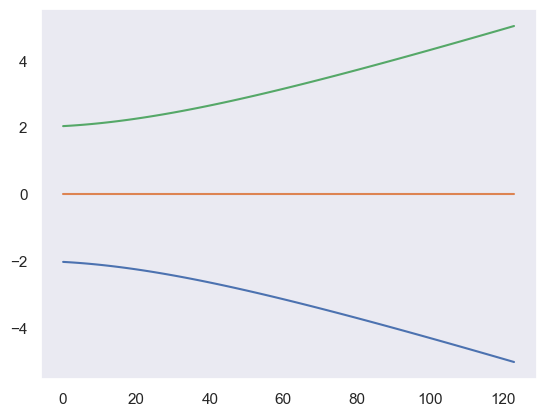

In [968]:
for v in vals0:
    plt.plot(v)

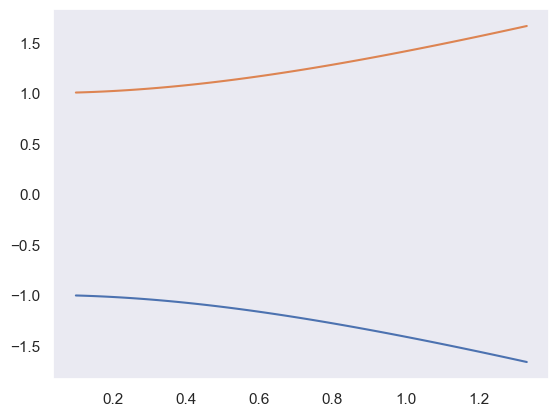

In [969]:
for v in vals1:
    plt.plot(lambdas,v)

In [970]:
def paper_ansatz(N_layers):
    theta = ParameterVector("m",2*N_layers)
    qr=QuantumRegister(2)
    qc=QuantumCircuit(qr)
    k=0
    for _ in range (N_layers):
        qc.ry(theta[k],qr[0])
        k+=1
        qc.cry(theta[k],qr[0],qr[1])
        k+=1
    return qc

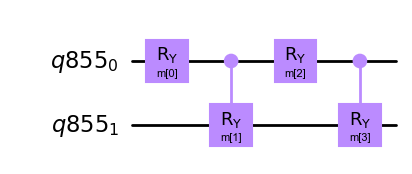

In [971]:
paper_ansatz(2).draw(output='mpl')

In [972]:
def Hamiltonian_ansatz(N_layers):
    theta = ParameterVector("m",8*N_layers)
    qr=QuantumRegister(2)
    qc=QuantumCircuit(qr)
    k=0
    for _ in range (N_layers):
        qc.h(qr[0])
        qc.rzz(theta[k],qr[0],qr[1])
        k+=1
        qc.h(qr[0])
        qc.h(qr[1])
        qc.rzz(theta[k],qr[0],qr[1])
        k+=1
        qc.h(qr[1])
        qc.rx(theta[k],qr[0])
        k+=1
        qc.rx(theta[k],qr[1])
        k+=1
        qc.rz(theta[k],qr[0])
        k+=1
        qc.rz(theta[k],qr[1])
        k+=1
        qc.rzz(theta[k],qr[0],qr[1])
        k+=1
        qc.barrier()
    return qc

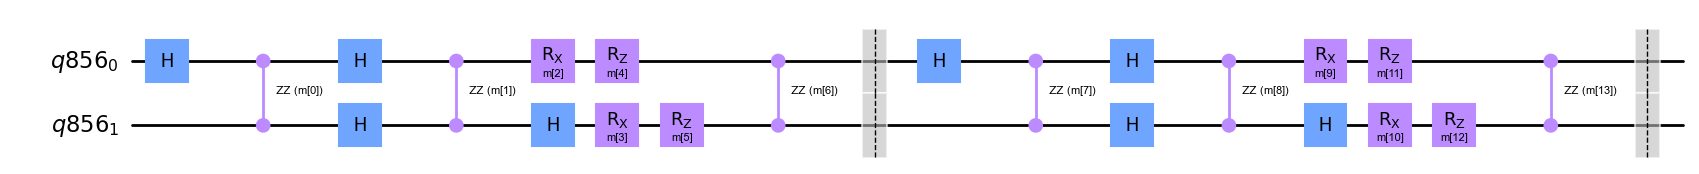

In [973]:
Hamiltonian_ansatz(2).draw(output='mpl')

In [974]:
def separable_ansatz(N_qubits,N_layers):
  theta = ParameterVector("m",2*N_qubits*N_layers)
  qr=QuantumRegister(N_qubits)
  qc=QuantumCircuit(qr)
  k=0
  for _ in range(N_layers):
    for i in range(N_qubits):
        qc.rx(theta[k],qr[i])
        k+=1
        qc.ry(theta[k],qr[i])
        k+=1

  return qc

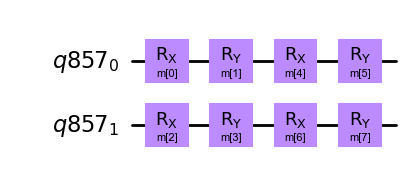

In [975]:
separable_ansatz(2,2).draw(output='mpl')

In [976]:
def Efficient_ansatz(N_qubits,N_layers):
    theta = ParameterVector("m",4*N_qubits*N_layers)
    qr=QuantumRegister(N_qubits)
    qc=QuantumCircuit(qr)
    k=0
    for i in range (N_qubits):
            qc.rx(theta[k],qr[i])
            k+=1
            qc.ry(theta[k],qr[i])
            k+=1
    for i in range (N_qubits-1):
        qc.cx(qr[i],qr[i+1])
    qc.barrier()
    for _ in range (N_layers-1):
        for i in range (N_qubits):
            qc.rx(theta[k],qr[i])
            k+=1
            qc.ry(theta[k],qr[i])
            k+=1
        for i in range (N_qubits-1):
            qc.cx(qr[i],qr[i+1])
        for i in range (N_qubits):
            qc.rx(theta[k],qr[i])
            k+=1
            qc.ry(theta[k],qr[i])
            k+=1
        qc.barrier()
    return qc

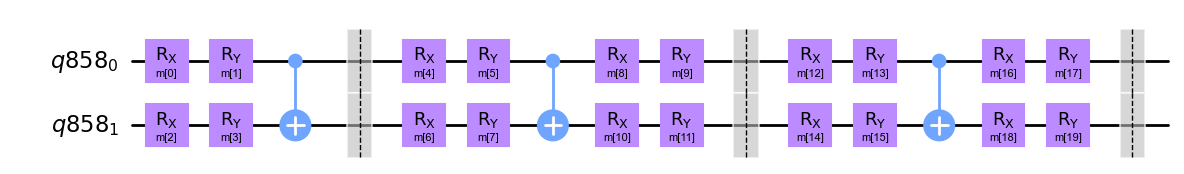

In [977]:
Efficient_ansatz(2,3).draw(output='mpl')

In [978]:
def Real_ansatz(N_qubits,N_layers):
    theta = ParameterVector("theta",4*N_qubits*N_layers)
    qr=QuantumRegister(N_qubits)
    qc=QuantumCircuit(qr)
    k=0
    for i in range (N_qubits):

            qc.ry(theta[k],qr[i])
            k+=1
    for i in range (N_qubits-1):
        qc.cx(qr[i],qr[i+1])
    qc.barrier()
    for _ in range (N_layers-1):
        for i in range (N_qubits):

            qc.ry(theta[k],qr[i])
            k+=1
        for i in range (N_qubits-1):
            qc.cx(qr[i],qr[i+1])
        for i in range (N_qubits):

            qc.ry(theta[k],qr[i])
            k+=1
        qc.barrier()
    return qc

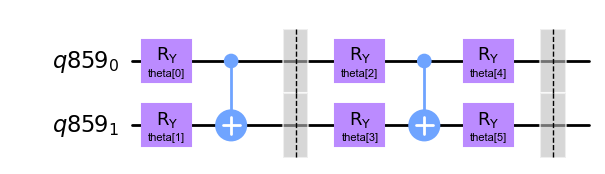

In [979]:
Real_ansatz(2,2).draw(output='mpl')

In [980]:
intermediate_info = []
def callback(data):
                intermediate_info.append(data)

cobyla=COBYLA(maxiter=1000, disp=True, rhobeg=0.1, tol=0.01, options=None)
adam=ADAM(maxiter=300, tol=1e-02, lr=0.1, beta_1=0.9, beta_2=0.99, noise_factor=1e-10, eps=1e-10, amsgrad=True, snapshot_dir=None)
g_d=GradientDescent(maxiter=300,learning_rate=0.1, tol=0.001, callback=None, perturbation=None)
spsa=SPSA(maxiter=100, blocking=False, allowed_increase=None, trust_region=False, learning_rate=None, perturbation=None, last_avg=1, resamplings=1, perturbation_dims=None, callback=None)

In [981]:
E=1
W=0
V=1
H0,H1=Lipkin_J2_decomposition(E,V,W)

val0,vecs0=np.linalg.eigh(H0)
val1,vecs1=np.linalg.eigh(H1)

In [982]:
val0

array([-4.00000000e+00, -1.16226473e-16,  4.00000000e+00])

In [983]:
ansatzs=[Real_ansatz(2,2),Efficient_ansatz(2,2),separable_ansatz(2,2)]
labels=['Real Amplitude Ansatz','Hardware Efficient Ansatz', 'Separable Ansatz']
energies=[]
for ans in ansatzs:
    intermediate_info= []
    initial_parameters=np.ones(ans.num_parameters)*np.pi/2
    estimator = Estimator(options={'shots': None})
    H0,H1=Lipkin_J2_decomposition_Pauli(E,V,W)
    custom_vqe = QiskitVQE(estimator,ans,cobyla,H0,initial_parameters=initial_parameters,callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    energies.append(intermediate_info)

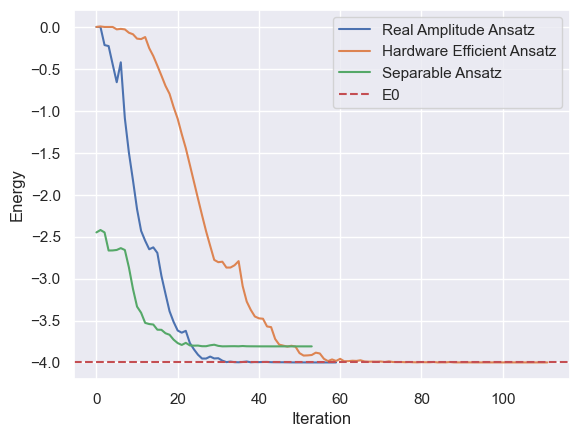

In [984]:
def callback(data):
                intermediate_info.append(data)
for i,opt_info in enumerate(energies):
    en=[]
    param=[]
    for info in opt_info:
        en.append(info[0])
        param.append(info[1])
    plt.plot(en,label=labels[i])
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
plt.axhline(y=val0[0], color='r', linestyle='--',label='E0')
plt.legend()
plt.grid()
plt.savefig('Lipkin_cobyla_ansatz_depth1.pdf')
plt.show()

In [985]:
ansatzs=[Efficient_ansatz(2,1),Efficient_ansatz(2,2),Efficient_ansatz(2,3),Efficient_ansatz(2,4)]
labels=['depth 1','depth 2', 'depth 3','depth 4']
energies=[]
for ans in ansatzs:
    intermediate_info= []
    initial_parameters=np.random.rand(ans.num_parameters)*np.pi/2
    estimator = Estimator(options={'shots': None})
    H0,H1=Lipkin_J2_decomposition_Pauli(E,V,W)
    custom_vqe = QiskitVQE(estimator,ans,cobyla,H0,initial_parameters=initial_parameters,callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    energies.append(intermediate_info)

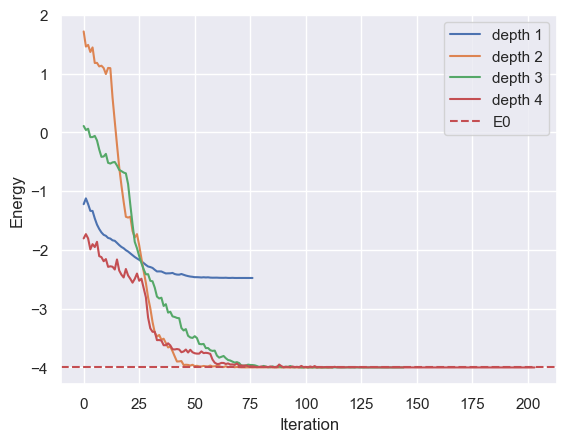

In [986]:
def callback(data):
                intermediate_info.append(data)
for i,opt_info in enumerate(energies):
    en=[]
    param=[]
    for info in opt_info:
        en.append(info[0])
        param.append(info[1])
    plt.plot(en,label=labels[i])
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
plt.axhline(y=val0[0], color='r', linestyle='--',label='E0')
plt.legend()
plt.grid()
plt.savefig('Lipkin_cobyla_efficient_depth.pdf')
plt.show()

In [987]:
ansatzs=[Real_ansatz(2,1),Real_ansatz(2,2),Real_ansatz(2,3),Real_ansatz(2,4)]
labels=['depth 1','depth 2', 'depth 3','depth 4']
energies=[]
for ans in ansatzs:
    intermediate_info= []
    initial_parameters=np.random.rand(ans.num_parameters)*np.pi/2
    estimator = Estimator(options={'shots': None})
    H0,H1=Lipkin_J2_decomposition_Pauli(E,V,W)
    custom_vqe = QiskitVQE(estimator,ans,cobyla,H0,initial_parameters=initial_parameters,callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    energies.append(intermediate_info)

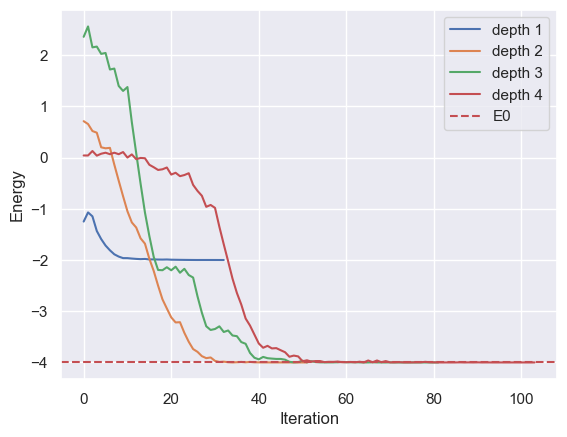

In [988]:
def callback(data):
                intermediate_info.append(data)
for i,opt_info in enumerate(energies):
    en=[]
    param=[]
    for info in opt_info:
        en.append(info[0])
        param.append(info[1])
    plt.plot(en,label=labels[i])
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
plt.axhline(y=val0[0], color='r', linestyle='--',label='E0')
plt.legend()
plt.grid()
plt.savefig('Lipkin_cobyla_real_depth.pdf')
plt.show()

In [989]:
ansatzs=[Hamiltonian_ansatz(1),Hamiltonian_ansatz(2),Hamiltonian_ansatz(3),Hamiltonian_ansatz(4)]
labels=['depth 1','depth 2', 'depth 3','depth 4']
energies=[]
for ans in ansatzs:
    intermediate_info= []
    initial_parameters=np.ones(ans.num_parameters)*np.pi/2
    estimator = Estimator(options={'shots': None})
    H0,H1=Lipkin_J2_decomposition_Pauli(E,V,W)
    custom_vqe = QiskitVQE(estimator,ans,cobyla,H0,initial_parameters=initial_parameters,callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    energies.append(intermediate_info)

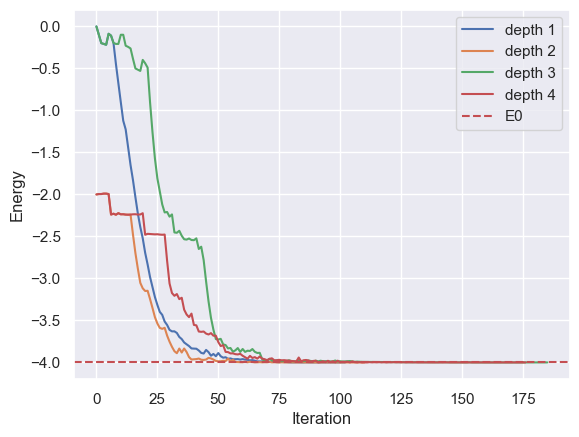

In [990]:
def callback(data):
                intermediate_info.append(data)
for i,opt_info in enumerate(energies):
    en=[]
    param=[]
    for info in opt_info:
        en.append(info[0])
        param.append(info[1])
    plt.plot(en,label=labels[i])
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
plt.axhline(y=val0[0], color='r', linestyle='--',label='E0')
plt.legend()
plt.grid()

plt.show()

In [991]:
ansatzs=[separable_ansatz(2,1),separable_ansatz(2,2),separable_ansatz(2,3),separable_ansatz(2,4)]
labels=['depth 1','depth 2', 'depth 3','depth 4']
energies=[]
for ans in ansatzs:
    intermediate_info= []
    initial_parameters=np.random.rand(ans.num_parameters)*np.pi/2
    estimator = Estimator(options={'shots': None})
    H0,H1=Lipkin_J2_decomposition_Pauli(E,V,W)
    custom_vqe = QiskitVQE(estimator,ans,cobyla,H0,initial_parameters=initial_parameters,callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    energies.append(intermediate_info)

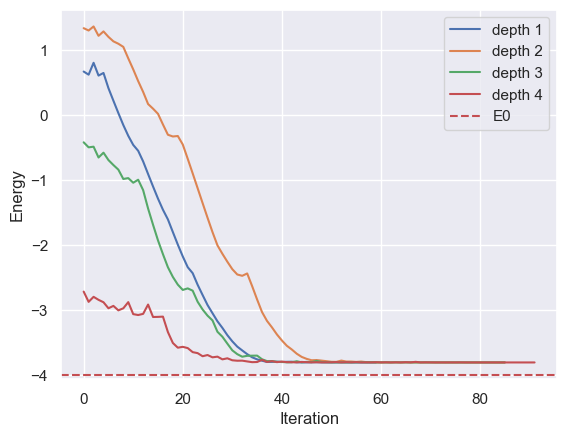

In [992]:
def callback(data):
                intermediate_info.append(data)
for i,opt_info in enumerate(energies):
    en=[]
    param=[]
    for info in opt_info:
        en.append(info[0])
        param.append(info[1])
    plt.plot(en,label=labels[i])
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
plt.axhline(y=val0[0], color='r', linestyle='--',label='E0')
plt.legend()
plt.grid()
plt.savefig('Lipkin_cobyla_separable_depth.pdf')
plt.show()

In [993]:
ansatzs=[paper_ansatz(1),paper_ansatz(2),paper_ansatz(3),paper_ansatz(4)]
labels=['depth 1','depth 2', 'depth 3','depth 4']
energies=[]
for ans in ansatzs:
    intermediate_info= []
    initial_parameters=np.random.rand(ans.num_parameters)*np.pi/2
    estimator = Estimator(options={'shots': None})
    H0,H1=Lipkin_J2_decomposition_Pauli(E,V,W)
    custom_vqe = QiskitVQE(estimator,ans,cobyla,H0,initial_parameters=initial_parameters,callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    energies.append(intermediate_info)

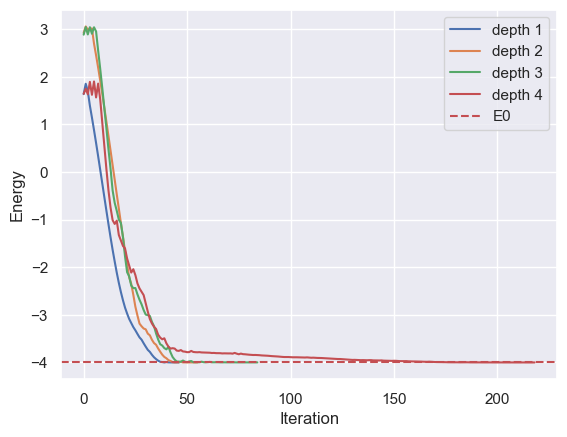

In [994]:
def callback(data):
                intermediate_info.append(data)
for i,opt_info in enumerate(energies):
    en=[]
    param=[]
    for info in opt_info:
        en.append(info[0])
        param.append(info[1])
    plt.plot(en,label=labels[i])
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
plt.axhline(y=val0[0], color='r', linestyle='--',label='E0')
plt.legend()
plt.grid()
plt.show()

In [995]:
gs_real=[]
gs_eff=[]
gs_sep=[]
gs_paper=[]
gs_ham=[]
optimizer=cobyla
lambdas=np.arange(0.01,4/3,4/30)
infos=[]

ansatzs=[Real_ansatz(2,2),Efficient_ansatz(2,2),separable_ansatz(2,2),Hamiltonian_ansatz(2),paper_ansatz(2)]
initial_parameters=[np.ones(ansatzs[0].num_parameters)*np.pi/2,np.ones(ansatzs[1].num_parameters)*np.pi/2,np.ones(ansatzs[2].num_parameters)*np.pi/2,np.ones(ansatzs[3].num_parameters)*np.pi/2,np.ones(ansatzs[4].num_parameters)*np.pi/2]
for V in lambdas:
    intermediate_info= []
    
    estimator = Estimator(options={'shots': None})
    H,H1=Lipkin_J2_decomposition_Pauli(E,V,W)
    
    custom_vqe = QiskitVQE(estimator,ansatzs[0],optimizer,H,initial_parameters=initial_parameters[0],callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)
    gs_real.append(result)

    
    custom_vqe = QiskitVQE(estimator,ansatzs[1],optimizer,H,initial_parameters=initial_parameters[1],callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)
    gs_eff.append(result)


    custom_vqe = QiskitVQE(estimator,ansatzs[2],optimizer,H,initial_parameters=initial_parameters[2],callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)
    gs_sep.append(result)

    custom_vqe = QiskitVQE(estimator,ansatzs[3],optimizer,H,initial_parameters=initial_parameters[3],callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)
    gs_ham.append(result)

    custom_vqe = QiskitVQE(estimator,ansatzs[4],optimizer,H,initial_parameters=initial_parameters[4],callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)
    gs_paper.append(result)

In [996]:
excited_real=[]
excited_eff=[]
excited_sep=[]
excited_paper=[]
excited_ham=[]
optimizer=cobyla
lambdas=np.arange(0.01,4/3,4/30)
infos=[]

ansatzs=[Real_ansatz(2,2),Efficient_ansatz(2,2),separable_ansatz(2,2),Hamiltonian_ansatz(2),paper_ansatz(2)]
initial_parameters=[np.ones(ansatzs[0].num_parameters)*np.pi/2,np.ones(ansatzs[1].num_parameters)*np.pi/2,np.ones(ansatzs[2].num_parameters)*np.pi/2,np.ones(ansatzs[3].num_parameters)*np.pi/2,np.ones(ansatzs[4].num_parameters)*np.pi/2]
for V in lambdas:
    intermediate_info= []
    
    estimator = Estimator(options={'shots': None})
    H,H1=Lipkin_J2_decomposition_Pauli(E,V,W)
    custom_vqe = QiskitVQE(estimator,ansatzs[0],optimizer,-H,initial_parameters=initial_parameters[0],callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)
    excited_real.append(-result)

    
    custom_vqe = QiskitVQE(estimator,ansatzs[1],optimizer,-H,initial_parameters=initial_parameters[1],callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)
    excited_eff.append(-result)


    custom_vqe = QiskitVQE(estimator,ansatzs[2],optimizer,-H,initial_parameters=initial_parameters[2],callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)
    excited_sep.append(-result)

    custom_vqe = QiskitVQE(estimator,ansatzs[3],optimizer,-H,initial_parameters=initial_parameters[3],callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)
    excited_ham.append(-result)

    custom_vqe = QiskitVQE(estimator,ansatzs[4],optimizer,-H,initial_parameters=initial_parameters[4],callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)
    excited_paper.append(-result)

In [997]:
lambdas_ex=np.arange(0.001,4/3,0.01)
vals_1=[]
for V in lambdas_ex:
    H,H1=Lipkin_J2_decomposition(E,V,W)
    val,vecs=np.linalg.eigh(H)
    vals_1.append(val)

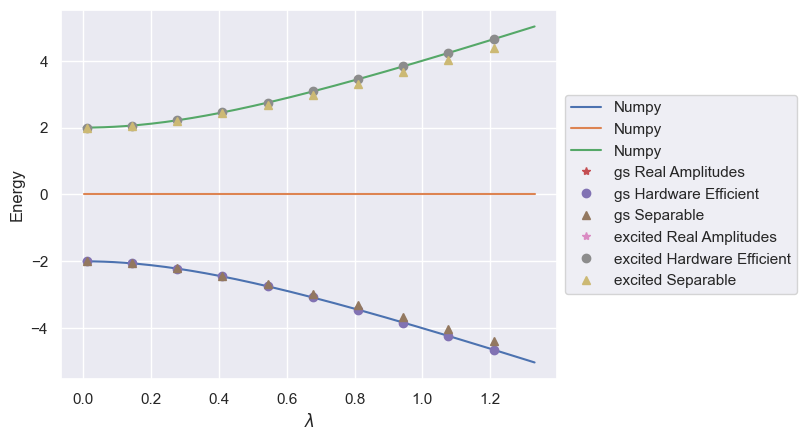

In [998]:
plt.plot(lambdas_ex,vals_1,label='Numpy')
plt.plot(lambdas,gs_real,linestyle='',marker='*',label='gs Real Amplitudes')
plt.plot(lambdas,gs_eff,linestyle='',marker='o',label='gs Hardware Efficient')
plt.plot(lambdas,gs_sep,linestyle='',marker='^',label='gs Separable')
#plt.plot(lambdas,gs_ham,linestyle='',marker='^',label='gs Hamiltonian')
#plt.plot(lambdas,gs_paper,linestyle='',marker='^',label='gs Paper')

plt.plot(lambdas,excited_real,linestyle='',marker='*',label='excited Real Amplitudes')
plt.plot(lambdas,excited_eff,linestyle='',marker='o',label='excited Hardware Efficient')
plt.plot(lambdas,excited_sep,linestyle='',marker='^',label='excited Separable')
#plt.plot(lambdas,excited_ham,linestyle='',marker='^',label='excited Hamiltonian')
#plt.plot(lambdas,excited_paper,linestyle='',marker='^',label='excited Paper')
plt.xlabel(r'$\lambda$')
plt.ylabel('Energy')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('Lipkin_spsa_lambda_exact.pdf',bbox_inches='tight')
plt.show()

In [999]:
gs_real=[]
gs_eff=[]
gs_sep=[]
gs_paper=[]
gs_ham=[]
optimizer=cobyla
lambdas=np.arange(0.01,4/3,4/30)
infos=[]

ansatzs=[Real_ansatz(2,2),Efficient_ansatz(2,2),separable_ansatz(2,2),Hamiltonian_ansatz(2),paper_ansatz(2)]
initial_parameters=[np.ones(ansatzs[0].num_parameters)*np.pi/2,np.ones(ansatzs[1].num_parameters)*np.pi/2,np.ones(ansatzs[2].num_parameters)*np.pi/2,np.ones(ansatzs[3].num_parameters)*np.pi/2,np.ones(ansatzs[4].num_parameters)*np.pi/2]
for V in lambdas:
    intermediate_info= []
    
    estimator = Estimator(options={'shots': 10000})
    H,H1=Lipkin_J2_decomposition_Pauli(E,V,W)
    
    custom_vqe = QiskitVQE(estimator,ansatzs[0],optimizer,H,initial_parameters=initial_parameters[0],callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)
    gs_real.append(result)

    
    custom_vqe = QiskitVQE(estimator,ansatzs[1],optimizer,H,initial_parameters=initial_parameters[1],callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)
    gs_eff.append(result)


    custom_vqe = QiskitVQE(estimator,ansatzs[2],optimizer,H,initial_parameters=initial_parameters[2],callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)
    gs_sep.append(result)

    custom_vqe = QiskitVQE(estimator,ansatzs[3],optimizer,H,initial_parameters=initial_parameters[3],callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)
    gs_ham.append(result)

    custom_vqe = QiskitVQE(estimator,ansatzs[4],optimizer,H,initial_parameters=initial_parameters[4],callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)
    gs_paper.append(result)

In [1000]:
excited_real=[]
excited_eff=[]
excited_sep=[]
excited_paper=[]
excited_ham=[]
optimizer=cobyla
lambdas=np.arange(0.01,4/3,4/30)
infos=[]

ansatzs=[Real_ansatz(2,2),Efficient_ansatz(2,2),separable_ansatz(2,2),Hamiltonian_ansatz(2),paper_ansatz(2)]
initial_parameters=[np.ones(ansatzs[0].num_parameters)*np.pi/2,np.ones(ansatzs[1].num_parameters)*np.pi/2,np.ones(ansatzs[2].num_parameters)*np.pi/2,np.ones(ansatzs[3].num_parameters)*np.pi/2,np.ones(ansatzs[4].num_parameters)*np.pi/2]
for V in lambdas:
    intermediate_info= []
    
    estimator = Estimator(options={'shots': 10000})
    H,H1=Lipkin_J2_decomposition_Pauli(E,V,W)
    custom_vqe = QiskitVQE(estimator,ansatzs[0],optimizer,-H,initial_parameters=initial_parameters[0],callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)
    excited_real.append(-result)

    
    custom_vqe = QiskitVQE(estimator,ansatzs[1],optimizer,-H,initial_parameters=initial_parameters[1],callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)
    excited_eff.append(-result)


    custom_vqe = QiskitVQE(estimator,ansatzs[2],optimizer,-H,initial_parameters=initial_parameters[2],callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)
    excited_sep.append(-result)

    custom_vqe = QiskitVQE(estimator,ansatzs[3],optimizer,-H,initial_parameters=initial_parameters[3],callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)
    excited_ham.append(-result)

    custom_vqe = QiskitVQE(estimator,ansatzs[4],optimizer,-H,initial_parameters=initial_parameters[4],callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)
    excited_paper.append(-result)

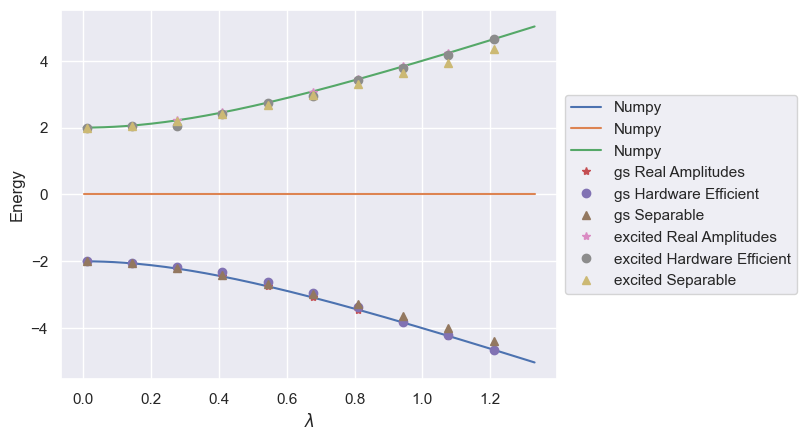

In [1001]:
plt.figure()
plt.plot(lambdas_ex,vals_1,label='Numpy')
plt.plot(lambdas,gs_real,linestyle='',marker='*',label='gs Real Amplitudes')
plt.plot(lambdas,gs_eff,linestyle='',marker='o',label='gs Hardware Efficient')
plt.plot(lambdas,gs_sep,linestyle='',marker='^',label='gs Separable')
#plt.plot(lambdas,gs_ham,linestyle='',marker='^',label='gs Hamiltonian')
#plt.plot(lambdas,gs_paper,linestyle='',marker='^',label='gs Paper')

plt.plot(lambdas,excited_real,linestyle='',marker='*',label='excited Real Amplitudes')
plt.plot(lambdas,excited_eff,linestyle='',marker='o',label='excited Hardware Efficient')
plt.plot(lambdas,excited_sep,linestyle='',marker='^',label='excited Separable')
#plt.plot(lambdas,excited_ham,linestyle='',marker='^',label='excited Hamiltonian')
#plt.plot(lambdas,excited_paper,linestyle='',marker='^',label='excited Paper')
plt.xlabel(r'$\lambda$')
plt.ylabel('Energy')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()
plt.savefig('Lipkin_spsa_lambda_10000.pdf',bbox_inches='tight')
plt.show()